![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [18]:
from datetime import datetime

# Initialize QuantConnect objects
qb = QuantBook()

In [19]:
S = "AMD"

In [20]:
symbol = qb.AddEquity(S).Symbol

# Define the date range
start_date = datetime(2017, 1, 1)
end_date = datetime(2023, 10, 1)

# Retrieve historical data
history = qb.History(QuoteBar,symbol, start_date, end_date, Resolution.Minute)
history = history.droplevel(level='symbol')
history = pd.DataFrame(history)
history['average'] = (history['low'] + history['high']) / 2
history['log_return'] = np.log(history['average'] / history['average'].shift(1))
history = history.dropna()
daily_volatility = history.groupby(history.index.date)['log_return'].std()
annualized_volatility = daily_volatility * np.sqrt(252)
y_target = annualized_volatility
y_target

2017-01-03    0.024396
2017-01-04    0.013256
2017-01-05    0.016087
2017-01-06    0.014318
2017-01-09    0.014945
                ...   
2023-09-25    0.013581
2023-09-26    0.015422
2023-09-27    0.015278
2023-09-28    0.015255
2023-09-29    0.019616
Name: log_return, Length: 1697, dtype: float64

In [21]:
history = qb.History(QuoteBar,symbol, start_date, end_date,Resolution.Minute)
history = history.droplevel(level='symbol')
history = pd.DataFrame(history)
history['ask_price'] = (history['asklow'] + history['askhigh']) / 2
history['bid_price'] = (history['bidlow'] + history['bidhigh']) / 2
df = history[['ask_price','bid_price','asksize', 'bidsize','high','low']]
df.rename(columns={'bidsize': 'bid_size', 'asksize': 'ask_size'}, inplace=True)
df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
df["volume"] = df.eval("ask_size + bid_size")
df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)") 
df["size_imbalance"] = df.eval("bid_size / ask_size")
df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))  # 中间价移动
df["price_spread"] = df["ask_price"] - df["bid_price"]
df["spread_intensity"] = df['price_spread'].diff()
df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance'] 
df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
df['wap'] = (df['bid_price']*df['ask_size'] + df['ask_price']*df['bid_size']) / (df['bid_size'] + df['ask_size'])
df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']

#global features
prices = ['bid_price', 'ask_price']
sizes = ['bid_size', 'ask_size']
global_stock_id_feats = {
    "median_size": df.groupby(df.index.date)["bid_size"].median() + df.groupby(df.index.date)["ask_size"].median(),
    "std_size": df.groupby(df.index.date)["bid_size"].std() + df.groupby(df.index.date)["ask_size"].std(),
    "ptp_size": df.groupby(df.index.date)["bid_size"].max() - df.groupby(df.index.date)["bid_size"].min(),
    "median_price": df.groupby(df.index.date)["bid_price"].median() + df.groupby(df.index.date)["ask_price"].median(),
    "std_price": df.groupby(df.index.date)["bid_price"].std() + df.groupby(df.index.date)["ask_price"].std(),
    "ptp_price": df.groupby(df.index.date)["bid_price"].max() - df.groupby(df.index.date)["ask_price"].min(),
}

# Adding the mean, std, skew, and kurt features for each price and size
aggregation_functions = ["mean", "std", "skew"]
for func in aggregation_functions:
    global_stock_id_feats[f"bid_price_{func}"] = df.groupby(df.index.date)['bid_price'].agg(func)
    global_stock_id_feats[f"ask_price_{func}"] = df.groupby(df.index.date)['ask_price'].agg(func)
    global_stock_id_feats[f"bid_size_{func}"] = df.groupby(df.index.date)['bid_size'].agg(func)
    global_stock_id_feats[f"ask_size_{func}"] = df.groupby(df.index.date)['ask_size'].agg(func)
global_stock_id_feats["bid_price_kurt"] = df.groupby(df.index.date)['bid_price'].apply(pd.Series.kurt)
global_stock_id_feats["ask_price_kurt"] = df.groupby(df.index.date)['ask_price'].apply(pd.Series.kurt)
global_stock_id_feats["bid_size_kurt"] = df.groupby(df.index.date)['bid_size'].apply(pd.Series.kurt)
global_stock_id_feats["ask_size_kurt"] = df.groupby(df.index.date)['ask_size'].apply(pd.Series.kurt)
global_feats_df = pd.DataFrame(global_stock_id_feats)


global_feats_df.reset_index(inplace=True)
global_feats_df.rename(columns={'index': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df.index.date)
global_feats_df['date'] = pd.to_datetime(global_feats_df['date'])
df = pd.merge(df, global_feats_df, on='date', how='left')
df = df.groupby('date').mean()
for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size','wap']:
    for window in [1, 2, 3, 5, 10]:
        df[f"{col}_diff_{window}"] = df[col].diff(window)
df.dropna(inplace = True)
df

/tmp/ipykernel_216/225968772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'bidsize': 'bid_size', 'asksize': 'ask_size'}, inplace=True)
/tmp/ipykernel_216/225968772.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
/tmp/ipykernel_216/225968772.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,ask_price,bid_price,ask_size,bid_size,high,low,mid_price,volume,liquidity_imbalance,size_imbalance,...,bid_size_diff_1,bid_size_diff_2,bid_size_diff_3,bid_size_diff_5,bid_size_diff_10,wap_diff_1,wap_diff_2,wap_diff_3,wap_diff_5,wap_diff_10
date,,,,,,,,,,,,,,,,,,,,,
2017-01-18,9.914769,9.904769,14004.615385,12852.564103,9.915923,9.903615,9.909769,26857.179487,-0.015860,1.351007,...,-4908.205128,-7233.846154,1958.205128,-3323.589744,1585.897436,-0.034332,-0.722965,-0.737090,-1.522153,-1.402670
2017-01-19,9.986192,9.976269,12021.025641,13283.589744,9.987872,9.974590,9.981231,25304.615385,0.006382,1.619169,...,431.025641,-4477.179487,-6802.820513,-4532.051282,553.846154,0.071563,0.037231,-0.651402,-1.282501,-1.410312
2017-01-20,9.786449,9.776474,12539.487179,13961.794872,9.786577,9.776346,9.781462,26501.282051,0.028358,1.708737,...,678.205128,1109.230769,-3798.974359,3067.435897,1977.948718,-0.199657,-0.128094,-0.162426,-0.865184,-1.583353
2017-01-23,9.882731,9.872756,14157.948718,13944.102564,9.882218,9.873269,9.877744,28102.051282,-0.027972,1.683677,...,-17.692308,660.512821,1091.538462,-6142.307692,567.179487,0.096000,-0.103657,-0.032094,-0.755059,-1.509628
2017-01-24,10.260474,10.250500,19402.820513,13820.769231,10.259718,10.251256,10.255487,33223.589744,-0.158449,1.031889,...,-123.333333,-141.025641,537.179487,-3940.000000,-4951.282051,0.377127,0.473127,0.273470,0.310701,-1.250829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,96.532115,96.518192,441.025641,399.230769,96.595372,96.454936,96.525154,840.256410,0.010986,1.659517,...,10.000000,-136.666667,48.205128,28.974359,-83.846154,-0.490014,-0.376252,-5.568695,-5.411352,-7.641801
2023-09-26,96.189782,96.177487,486.666667,555.897436,96.249321,96.117949,96.183635,1042.564103,0.005360,2.086416,...,156.666667,166.666667,20.000000,158.461538,254.102564,-0.341616,-0.831629,-0.717868,-5.653706,-9.325873
2023-09-27,97.691551,97.677872,408.974359,368.974359,97.760103,97.609321,97.684712,777.948718,-0.003728,1.488192,...,-186.923077,-30.256410,-20.256410,17.948718,38.461538,1.500955,1.159340,0.669326,-4.409356,-9.983923


In [22]:
single_fundamental_history = qb.History[Fundamental](symbol, start_date, end_date)
def create_fundamentals_dataframe(single_fundamental_history):
    data = []
    for fundamental in single_fundamental_history:
        row = {
            "Date": fundamental.EndTime,
            "Symbol": fundamental.Symbol,
            "PE Ratio": fundamental.ValuationRatios.PERatio,
            "PB Ratio": fundamental.ValuationRatios.PBRatio,
            "PS Ratio": fundamental.ValuationRatios.PSRatio,
            "Earning Yield": fundamental.ValuationRatios.EarningYield,
            "Current Assets": fundamental.FinancialStatements.BalanceSheet.CurrentAssets.Value,
            "Current Liabilities": fundamental.FinancialStatements.BalanceSheet.CurrentLiabilities.Value,
            "Operating Cash Flow": fundamental.FinancialStatements.CashFlowStatement.OperatingCashFlow.Value,
            "Basic EPS": fundamental.EarningReports.BasicEPS.Value,
            "Diluted EPS": fundamental.EarningReports.DilutedEPS.Value,
            "Market Cap": fundamental.CompanyProfile.MarketCap,
            "ROE": fundamental.OperationRatios.ROE.Value,
            "ROA": fundamental.OperationRatios.ROA.Value
        }
        data.append(row)
    df1 = pd.DataFrame(data)

    # Set the date as the index
    df1.set_index('Date', inplace=True)

    return df1
fundamental_df = create_fundamentals_dataframe(single_fundamental_history)
fundamental_df = fundamental_df[~fundamental_df.index.duplicated(keep='first')]
fundamental_df

,Symbol,PE Ratio,PB Ratio,PS Ratio,Earning Yield,Current Assets,Current Liabilities,Operating Cash Flow,Basic EPS,Diluted EPS,Market Cap,ROE,ROA
Date,,,,,,,,,,,,,
2017-01-04,AMD,38.142857,27.540000,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,10510691239,-248.500000,-0.154588
2017-01-05,AMD,38.142857,27.540000,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,10510691239,-248.500000,-0.154588
2017-01-06,AMD,38.142857,27.540000,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,10510691239,-248.500000,-0.154588
2017-01-07,AMD,38.142857,27.540000,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,10510691239,-248.500000,-0.154588
2017-01-10,AMD,38.142857,27.540000,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,10510691239,-248.500000,-0.154588
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,AMD,602.105263,3.097954,7.812049,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,170808778293,0.042412,0.033000
2023-09-27,AMD,602.105263,3.097954,7.812049,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,170808778293,0.042412,0.033000
2023-09-28,AMD,602.105263,3.097954,7.812049,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,170808778293,0.042412,0.033000


In [23]:
merged_df = pd.merge(df, fundamental_df, left_index=True, right_index=True, how='left')
merged_df.fillna(method='ffill', inplace=True)
merged_df

,ask_price,bid_price,ask_size,bid_size,high,low,mid_price,volume,liquidity_imbalance,size_imbalance,...,PS Ratio,Earning Yield,Current Assets,Current Liabilities,Operating Cash Flow,Basic EPS,Diluted EPS,Market Cap,ROE,ROA
date,,,,,,,,,,,,,,,,,,,,,
2017-01-18,9.914769,9.904769,14004.615385,12852.564103,9.915923,9.903615,9.909769,26857.179487,-0.015860,1.351007,...,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
2017-01-19,9.986192,9.976269,12021.025641,13283.589744,9.987872,9.974590,9.981231,25304.615385,0.006382,1.619169,...,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
2017-01-20,9.786449,9.776474,12539.487179,13961.794872,9.786577,9.776346,9.781462,26501.282051,0.028358,1.708737,...,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
2017-01-23,9.882731,9.872756,14157.948718,13944.102564,9.882218,9.873269,9.877744,28102.051282,-0.027972,1.683677,...,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
2017-01-24,10.260474,10.250500,19402.820513,13820.769231,10.259718,10.251256,10.255487,33223.589744,-0.158449,1.031889,...,2.196369,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,96.532115,96.518192,441.025641,399.230769,96.595372,96.454936,96.525154,840.256410,0.010986,1.659517,...,7.812049,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,1.708088e+11,0.042412,0.033000
2023-09-26,96.189782,96.177487,486.666667,555.897436,96.249321,96.117949,96.183635,1042.564103,0.005360,2.086416,...,7.812049,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,1.708088e+11,0.042412,0.033000
2023-09-27,97.691551,97.677872,408.974359,368.974359,97.760103,97.609321,97.684712,777.948718,-0.003728,1.488192,...,7.812049,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,1.708088e+11,0.042412,0.033000


In [24]:
oil = qb.AddCfd("WTICOUSD", Resolution.Daily).Symbol
gold = qb.AddFuture(Futures.Metals.Gold, Resolution.Daily).Symbol
eurusd = qb.AddForex("EURUSD", Resolution.Daily).Symbol


In [25]:
train = pd.merge(merged_df, y_target, left_index=True, right_index=True, how='left')
train.rename(columns={'log_return': 'vol'}, inplace=True)
train['vol'] = train['vol'].shift(-1)
train.dropna(inplace = True)
train.drop(columns='Symbol', inplace = True)
#train = train.sample(frac=1).reset_index(drop=True)
train

,ask_price,bid_price,ask_size,bid_size,high,low,mid_price,volume,liquidity_imbalance,size_imbalance,...,Earning Yield,Current Assets,Current Liabilities,Operating Cash Flow,Basic EPS,Diluted EPS,Market Cap,ROE,ROA,vol
date,,,,,,,,,,,,,,,,,,,,,
2017-01-18,9.914769,9.904769,14004.615385,12852.564103,9.915923,9.903615,9.909769,26857.179487,-0.015860,1.351007,...,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588,0.020689
2017-01-19,9.986192,9.976269,12021.025641,13283.589744,9.987872,9.974590,9.981231,25304.615385,0.006382,1.619169,...,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588,0.018006
2017-01-20,9.786449,9.776474,12539.487179,13961.794872,9.786577,9.776346,9.781462,26501.282051,0.028358,1.708737,...,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588,0.013236
2017-01-23,9.882731,9.872756,14157.948718,13944.102564,9.882218,9.873269,9.877744,28102.051282,-0.027972,1.683677,...,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588,0.015948
2017-01-24,10.260474,10.250500,19402.820513,13820.769231,10.259718,10.251256,10.255487,33223.589744,-0.158449,1.031889,...,-0.0600,2.320000e+09,1.403000e+09,-2.260000e+08,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588,0.035481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-22,97.021872,97.009244,418.974359,389.230769,97.086449,96.944667,97.015558,808.205128,-0.044249,1.759689,...,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,1.708088e+11,0.042412,0.033000,0.013581
2023-09-25,96.532115,96.518192,441.025641,399.230769,96.595372,96.454936,96.525154,840.256410,0.010986,1.659517,...,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,1.708088e+11,0.042412,0.033000,0.015422
2023-09-26,96.189782,96.177487,486.666667,555.897436,96.249321,96.117949,96.183635,1042.564103,0.005360,2.086416,...,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,1.708088e+11,0.042412,0.033000,0.015278


In [26]:
X_train = train.iloc[:996,:-1]
y_train = train.iloc[:996,-1]

In [27]:
X_train

,ask_price,bid_price,ask_size,bid_size,high,low,mid_price,volume,liquidity_imbalance,size_imbalance,...,PS Ratio,Earning Yield,Current Assets,Current Liabilities,Operating Cash Flow,Basic EPS,Diluted EPS,Market Cap,ROE,ROA
date,,,,,,,,,,,,,,,,,,,,,
2017-01-18,9.914769,9.904769,14004.615385,12852.564103,9.915923,9.903615,9.909769,26857.179487,-0.015860,1.351007,...,2.196369,-0.060,2.320000e+09,1.403000e+09,-226000000.0,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
2017-01-19,9.986192,9.976269,12021.025641,13283.589744,9.987872,9.974590,9.981231,25304.615385,0.006382,1.619169,...,2.196369,-0.060,2.320000e+09,1.403000e+09,-226000000.0,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
2017-01-20,9.786449,9.776474,12539.487179,13961.794872,9.786577,9.776346,9.781462,26501.282051,0.028358,1.708737,...,2.196369,-0.060,2.320000e+09,1.403000e+09,-226000000.0,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
2017-01-23,9.882731,9.872756,14157.948718,13944.102564,9.882218,9.873269,9.877744,28102.051282,-0.027972,1.683677,...,2.196369,-0.060,2.320000e+09,1.403000e+09,-226000000.0,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
2017-01-24,10.260474,10.250500,19402.820513,13820.769231,10.259718,10.251256,10.255487,33223.589744,-0.158449,1.031889,...,2.196369,-0.060,2.320000e+09,1.403000e+09,-226000000.0,-0.84,-0.84,1.051069e+10,-248.500000,-0.154588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,92.059000,92.047487,494.102564,525.641026,92.100423,92.006064,92.053244,1019.743590,0.048607,2.216577,...,12.814966,0.008,4.597000e+09,2.359000e+09,493000000.0,0.31,0.30,1.115695e+11,0.166626,0.064437
2020-12-24,91.898143,91.885905,455.238095,693.333333,91.951190,91.832857,91.892024,1148.571429,0.075058,2.588690,...,12.814966,0.008,4.597000e+09,2.359000e+09,493000000.0,0.31,0.30,1.115695e+11,0.166626,0.064437
2020-12-28,91.961128,91.950103,563.846154,459.230769,92.006526,91.904705,91.955615,1023.076923,0.011983,1.781764,...,12.814966,0.008,4.597000e+09,2.359000e+09,493000000.0,0.31,0.30,1.115695e+11,0.166626,0.064437


In [28]:
X_test = train.iloc[997:,:-1]
y_test = train.iloc[997:,-1]

In [29]:
X_test

,ask_price,bid_price,ask_size,bid_size,high,low,mid_price,volume,liquidity_imbalance,size_imbalance,...,PS Ratio,Earning Yield,Current Assets,Current Liabilities,Operating Cash Flow,Basic EPS,Diluted EPS,Market Cap,ROE,ROA
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,92.648269,92.635141,711.538462,365.384615,92.731154,92.552256,92.641705,1076.923077,-0.068405,1.415064,...,12.814966,0.0080,4.597000e+09,2.359000e+09,4.930000e+08,0.31,0.30,1.115695e+11,0.166626,0.064437
2021-01-05,92.186731,92.175244,798.717949,484.615385,92.243128,92.118846,92.180987,1283.333333,-0.053010,1.669549,...,12.683580,0.0081,4.597000e+09,2.359000e+09,4.930000e+08,0.31,0.30,1.110608e+11,0.574792,0.332221
2021-01-06,91.210679,91.198808,442.307692,469.743590,91.284385,91.125103,91.204744,912.051282,0.008620,2.030117,...,12.683580,0.0081,4.597000e+09,2.359000e+09,4.930000e+08,0.31,0.30,1.110608e+11,0.574792,0.332221
2021-01-07,94.494218,94.482885,547.179487,530.512821,94.555128,94.421974,94.488551,1077.692308,0.017927,1.903999,...,12.683580,0.0081,4.597000e+09,2.359000e+09,4.930000e+08,0.31,0.30,1.110608e+11,0.574792,0.332221
2021-01-08,94.305128,94.293115,654.358974,461.025641,94.377051,94.221192,94.299122,1115.384615,-0.018070,1.769364,...,12.683580,0.0081,4.597000e+09,2.359000e+09,4.930000e+08,0.31,0.30,1.110608e+11,0.574792,0.332221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-22,97.021872,97.009244,418.974359,389.230769,97.086449,96.944667,97.015558,808.205128,-0.044249,1.759689,...,7.812049,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,1.708088e+11,0.042412,0.033000
2023-09-25,96.532115,96.518192,441.025641,399.230769,96.595372,96.454936,96.525154,840.256410,0.010986,1.659517,...,7.812049,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,1.708088e+11,0.042412,0.033000
2023-09-26,96.189782,96.177487,486.666667,555.897436,96.249321,96.117949,96.183635,1042.564103,0.005360,2.086416,...,7.812049,-0.0004,1.501900e+10,6.369000e+09,3.565000e+09,0.85,0.84,1.708088e+11,0.042412,0.033000


In [30]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_train

/opt/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (996). n_quantiles is set to n_samples.
  warnings.warn(


,ask_price,bid_price,ask_size,bid_size,high,low,mid_price,volume,liquidity_imbalance,size_imbalance,...,PS Ratio,Earning Yield,Current Assets,Current Liabilities,Operating Cash Flow,Basic EPS,Diluted EPS,Market Cap,ROE,ROA
0,-2.324467,-2.324467,0.575691,0.502842,-2.324467,-2.324467,-2.324467,0.531641,-0.170876,-1.569279,...,-1.135224,-5.199338,-2.288463,-0.616312,-5.199338,-5.199338,-5.199338,-1.372688,-5.199338,-5.199338
1,-2.195319,-2.195319,0.407805,0.540366,-2.195319,-2.195319,-2.195319,0.460404,0.271600,-0.923438,...,-1.135224,-5.199338,-2.288463,-0.616312,-5.199338,-5.199338,-5.199338,-1.372688,-5.199338,-5.199338
2,-2.510375,-2.510375,0.449229,0.623946,-2.574096,-2.510375,-2.510375,0.514310,0.667391,-0.718642,...,-1.135224,-5.199338,-2.288463,-0.616312,-5.199338,-5.199338,-5.199338,-1.372688,-5.199338,-5.199338
3,-2.455462,-2.455462,0.596631,0.620888,-2.455462,-2.455462,-2.455462,0.587625,-0.413286,-0.775252,...,-1.135224,-5.199338,-2.288463,-0.616312,-5.199338,-5.199338,-5.199338,-1.372688,-5.199338,-5.199338
4,-1.784319,-1.784319,1.072675,0.599644,-1.784319,-1.784319,-1.784319,0.830900,-2.195319,-2.574096,...,-1.135224,-5.199338,-2.288463,-0.616312,-5.199338,-5.199338,-5.199338,-1.372688,-5.199338,-5.199338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,2.224265,2.224265,-2.255203,-2.072799,2.224265,2.224265,2.224265,-2.324467,1.054930,0.356311,...,1.856962,0.250747,1.202562,1.202562,5.199338,0.349608,0.349608,2.324467,0.307065,0.307065
992,2.168104,2.168104,-2.510375,-1.451166,2.168104,2.142406,2.168104,-1.864072,1.586779,0.962739,...,1.856962,0.250747,1.202562,1.202562,5.199338,0.349608,0.349608,2.324467,0.307065,0.307065
993,2.195319,2.195319,-1.878583,-2.650377,2.195319,2.195319,2.195319,-2.271519,0.385999,-0.546206,...,1.856962,0.250747,1.202562,1.202562,5.199338,0.349608,0.349608,2.324467,0.307065,0.307065
994,2.011989,2.011989,-2.118050,-2.876580,2.011989,2.011989,2.011989,-2.746137,-0.245551,-0.432571,...,1.856962,0.250747,1.202562,1.202562,5.199338,0.349608,0.349608,2.324467,0.307065,0.307065


In [31]:
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_test

,ask_price,bid_price,ask_size,bid_size,high,low,mid_price,volume,liquidity_imbalance,size_imbalance,...,PS Ratio,Earning Yield,Current Assets,Current Liabilities,Operating Cash Flow,Basic EPS,Diluted EPS,Market Cap,ROE,ROA
0,2.321361,2.320337,-1.493724,-3.319288,2.325737,2.312165,2.320848,-2.021211,-1.079011,-1.418101,...,1.856962,0.250747,1.202562,1.202562,5.199338,0.349608,0.349608,2.324467,0.307065,0.307065
1,2.255465,2.255517,-1.323414,-2.371491,2.255648,2.255333,2.255491,-1.677384,-0.855183,-0.798468,...,1.726665,0.307065,1.202562,1.202562,5.199338,0.349608,0.349608,2.049554,5.199338,5.199338
2,2.047140,2.047140,-2.663520,-2.479499,2.047651,2.046676,2.047140,-2.900688,0.327832,0.051616,...,1.726665,0.307065,1.202562,1.202562,5.199338,0.349608,0.349608,2.049554,5.199338,5.199338
3,2.648656,2.648772,-1.962406,-2.026500,2.646801,2.650489,2.648714,-2.019998,0.491052,-0.274271,...,1.726665,0.307065,1.202562,1.202562,5.199338,0.349608,0.349608,2.049554,5.199338,5.199338
4,2.625785,2.625825,-1.574795,-2.604057,2.625669,2.625945,2.625805,-1.916233,-0.213273,-0.586536,...,1.726665,0.307065,1.202562,1.202562,5.199338,0.349608,0.349608,2.049554,5.199338,5.199338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,5.199338,5.199338,-2.752858,-3.144190,5.199338,5.199338,5.199338,-2.972560,-0.702945,-0.626886,...,0.809621,-0.634364,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,-0.695995,-0.012863
685,2.782221,2.781686,-2.668700,-3.092402,2.785726,2.779032,2.781953,-2.948715,0.375231,-0.814152,...,0.809621,-0.634364,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,-0.695995,-0.012863
686,2.734066,2.734060,-2.335614,-1.833464,2.734354,2.733780,2.734063,-2.141115,0.232245,0.124070,...,0.809621,-0.634364,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,-0.695995,-0.012863
687,5.199338,5.199338,-2.767057,-3.285689,5.199338,5.199338,5.199338,-2.996735,0.056710,-1.258351,...,0.809621,-0.634364,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,-0.695995,-0.012863


In [32]:
# 0-996 train, others test

X_train.shape

(996, 76)

In [33]:
X_test.shape

(689, 76)

In [34]:
y_train.shape

(996,)

In [35]:
def windowed_dataset(x, y, window_size):
    X = []
    Y = []
    for i in range(len(x) - window_size):
        X.append(x[i:i+window_size])
        Y.append(y[i+window_size])
    return np.array(X), np.array(Y)

In [36]:
mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, 10)

In [37]:
mat_X_test, mat_y_test = windowed_dataset(X_test, y_test, 10)

In [38]:
mat_X_train.shape[2]

76

In [39]:
batch_size = 1

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

mat_X_train = torch.tensor(mat_X_train, dtype=torch.float32)
mat_y_train = torch.tensor(mat_y_train, dtype=torch.float32)
train_dataset = TensorDataset(mat_X_train, mat_y_train)

In [41]:
mat_X_test = torch.tensor(mat_X_test, dtype=torch.float32)
mat_y_test = torch.tensor(mat_y_test, dtype=torch.float32)
test_dataset = TensorDataset(mat_X_test, mat_y_test)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [43]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
for data in train_loader:
    print(data[0].shape)
    break

torch.Size([1, 10, 76])


In [45]:
for data in test_loader:
    print(data[0].shape)
    break

torch.Size([1, 10, 76])


In [46]:
print((10 - 4) // 2 + 1)

4


In [47]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import joblib
import torch
import torch.nn as nn


class LSTM3(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM3, self).__init__()

        # Adjust the in_channels of Conv1D to match the input dimension
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=4, stride=2)

        self.new_feature_size = 4  # Update this if input length changes

        self.lstm1 = nn.LSTM(input_size=32, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=hidden_dim * 2, hidden_size=hidden_dim // 2, num_layers=1, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim // 2 * 2, output_dim)

    def forward(self, x):
        # [1, 10, 76]
        x = x.transpose(1, 2)  #  [1, 76, 10]

        # Apply Conv1D
        x = torch.relu(self.conv1d(x))  # [1, 32, new_feature_size=4]

        # Transpose for LSTM layers
        x = x.transpose(1, 2)  # [1, new_feature_size, 32]

        # Adjust for LSTM input
        x = x[:, :self.new_feature_size, :]  # Ensure x matches the new_feature_size

        # First LSTM layer
        x, _ = self.lstm1(x)  # [1, new_feature_size, hidden_dim * 2]

        # Second LSTM layer
        x, _ = self.lstm2(x)  # [1, new_feature_size, hidden_dim // 2 * 2]

        # Select the last time step
        x = x[:, -1, :]  # [batch_size, hidden_dim] -> [1, hidden_dim // 2 * 2]

        # Dense layer
        x = self.fc(x)  # [batch_size, output_dim]

        return x


In [48]:
from tqdm import trange

lstm_3 = LSTM3(input_dim=mat_X_train.shape[2], hidden_dim=128, num_layers=1, output_dim=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_3.parameters(), lr=0.0001)

epochs = 24
train_loss_history = []
val_loss_history = []
train_rmspe_history = []
val_rmspe_history = []

for epoch in trange(epochs):
    lstm_3.train()
    train_loss = 0
    for inputs, targets in train_loader:
        #inputs = inputs.unsqueeze(2)
        optimizer.zero_grad()
        outputs = lstm_3(inputs)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    # train_rmspe = calculate_rmspe(targets, outputs)
    # train_rmspe_history.append(train_rmspe.item())
    print(train_loss)

    # lstm_3.eval()
    # val_loss = 0
    # with torch.no_grad():
    #     for inputs, targets in test_loader:
    #         #inputs = inputs.unsqueeze(2)
    #         outputs = lstm_3(inputs)
    #         outputs = outputs.squeeze(1)
    #         val_loss += criterion(outputs, targets).item()
    #     val_loss /= len(val_loader)
    # val_loss_history.append(val_loss)
    # val_rmspe = calculate_rmspe(targets, outputs)
    # val_rmspe_history.append(val_rmspe.item())

  4%|▍         | 1/24 [01:02<23:58, 62.52s/it]

0.00022962991603766046


  8%|▊         | 2/24 [02:16<25:24, 69.28s/it]

0.0001967892169626526


 12%|█▎        | 3/24 [03:25<24:09, 69.01s/it]

0.00018135725867213676


 17%|█▋        | 4/24 [05:59<34:09, 102.49s/it]

0.00017209681208684753


 21%|██        | 5/24 [07:34<31:38, 99.93s/it] 

0.00016160635398965173


 25%|██▌       | 6/24 [09:28<31:23, 104.61s/it]

0.00015280384385214


 29%|██▉       | 7/24 [11:05<28:59, 102.32s/it]

0.00014404275529369346


 33%|███▎      | 8/24 [12:59<28:15, 105.94s/it]

0.00013271762175498563


 38%|███▊      | 9/24 [14:36<25:46, 103.08s/it]

0.0001249420720382119


 42%|████▏     | 10/24 [16:19<24:02, 103.06s/it]

0.00011382642464906278


 46%|████▌     | 11/24 [18:02<22:19, 103.01s/it]

0.00010656290237353208


 50%|█████     | 12/24 [22:39<31:13, 156.12s/it]

9.636735274764288e-05


 54%|█████▍    | 13/24 [27:26<35:51, 195.59s/it]

8.497252538377083e-05


 58%|█████▊    | 14/24 [32:53<39:13, 235.31s/it]

7.263351876671683e-05


 62%|██████▎   | 15/24 [38:29<39:52, 265.81s/it]

6.520233336556611e-05


 67%|██████▋   | 16/24 [44:00<38:03, 285.43s/it]

5.8481518520320815e-05


 71%|███████   | 17/24 [49:12<34:13, 293.36s/it]

5.313878016339984e-05


 75%|███████▌  | 18/24 [54:42<30:25, 304.28s/it]

4.795079836771058e-05


 79%|███████▉  | 19/24 [1:00:01<25:43, 308.79s/it]

4.6326452330981004e-05


 83%|████████▎ | 20/24 [1:05:33<21:02, 315.61s/it]

4.104489767591926e-05


 88%|████████▊ | 21/24 [1:11:12<16:08, 322.81s/it]

4.582652597173046e-05


 92%|█████████▏| 22/24 [1:16:47<10:52, 326.35s/it]

4.524632867480433e-05


 96%|█████████▌| 23/24 [1:28:37<07:21, 441.45s/it]

4.584844665886134e-05


100%|██████████| 24/24 [1:37:29<00:00, 243.71s/it]

3.9661204749297946e-05


In [49]:
torch.save(lstm_3.state_dict(), 'lstm3_24epoch_lr.pth')

In [50]:
import pickle

# Serialize the model into bytes
lstm_3_model_bytes = pickle.dumps(lstm_3)

qb.ObjectStore.SaveBytes("lstm_3_24epochlr_model_key", lstm_3_model_bytes)

True

In [51]:
import joblib

model_key = "lstm_3_24epochlr"
file_name = qb.ObjectStore.GetFilePath(model_key)
joblib.dump(lstm_3, file_name)

['/home/jovyan/work/storage/lstm_3_24epochlr']

In [52]:
# train another 24 epoch
for epoch in trange(epochs):
    lstm_3.train()
    train_loss = 0
    for inputs, targets in train_loader:
        #inputs = inputs.unsqueeze(2)
        optimizer.zero_grad()
        outputs = lstm_3(inputs)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    # train_rmspe = calculate_rmspe(targets, outputs)
    # train_rmspe_history.append(train_rmspe.item())
    print(train_loss)

  4%|▍         | 1/24 [01:01<23:24, 61.07s/it]

2.8468540110021783e-05


  8%|▊         | 2/24 [02:29<28:14, 77.03s/it]

2.83418867109875e-05


 12%|█▎        | 3/24 [04:09<30:38, 87.56s/it]

3.80349896154956e-05


 17%|█▋        | 4/24 [05:48<30:45, 92.28s/it]

3.304552921668732e-05


 21%|██        | 5/24 [07:28<30:02, 94.84s/it]

5.2786312900178396e-05


 25%|██▌       | 6/24 [09:11<29:15, 97.55s/it]

3.914694804483023e-05


 29%|██▉       | 7/24 [10:51<27:53, 98.42s/it]

2.2943543013160214e-05


 33%|███▎      | 8/24 [12:29<26:15, 98.44s/it]

3.3248972202111477e-05


 38%|███▊      | 9/24 [14:04<24:20, 97.37s/it]

3.4599845546743664e-05


 42%|████▏     | 10/24 [15:47<23:05, 98.95s/it]

2.3784886210760166e-05


 46%|████▌     | 11/24 [17:27<21:30, 99.27s/it]

2.364215036230985e-05


 50%|█████     | 12/24 [19:09<20:01, 100.16s/it]

2.107923692296551e-05


 54%|█████▍    | 13/24 [20:46<18:11, 99.27s/it] 

2.146003033052629e-05


 58%|█████▊    | 14/24 [22:24<16:27, 98.79s/it]

2.3929492066062654e-05


 62%|██████▎   | 15/24 [24:04<14:51, 99.10s/it]

2.1792528732697836e-05


 67%|██████▋   | 16/24 [25:49<13:26, 100.87s/it]

2.1605890807572076e-05


 71%|███████   | 17/24 [27:24<11:35, 99.35s/it] 

2.6608535864453752e-05


 75%|███████▌  | 18/24 [29:13<10:12, 102.10s/it]

2.3755131228159573e-05


 79%|███████▉  | 19/24 [32:22<10:41, 128.29s/it]

2.1711271165454822e-05


 83%|████████▎ | 20/24 [34:50<08:56, 134.03s/it]

2.11256534844847e-05


 88%|████████▊ | 21/24 [37:03<06:41, 133.87s/it]

2.452844751082314e-05


 92%|█████████▏| 22/24 [38:07<03:45, 112.75s/it]

1.583709459476318e-05


 96%|█████████▌| 23/24 [39:25<01:42, 102.29s/it]

1.6469322471466052e-05


100%|██████████| 24/24 [40:55<00:00, 102.33s/it]

2.1713284647851497e-05


In [53]:
# train another 24 epoch
for epoch in trange(3):
    lstm_3.train()
    train_loss = 0
    for inputs, targets in train_loader:
        #inputs = inputs.unsqueeze(2)
        optimizer.zero_grad()
        outputs = lstm_3(inputs)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    # train_rmspe = calculate_rmspe(targets, outputs)
    # train_rmspe_history.append(train_rmspe.item())
    print(train_loss)

 33%|███▎      | 1/3 [01:02<02:05, 62.78s/it]

2.311631504632765e-05


 67%|██████▋   | 2/3 [02:15<01:08, 68.50s/it]

1.5943450542920385e-05


100%|██████████| 3/3 [04:24<00:00, 88.29s/it]

1.3639012008909183e-05


In [54]:
torch.save(lstm_3.state_dict(), 'lstm3_47epochlr.pth')

In [55]:
import pickle

# Serialize the model into bytes
lstm_3_model_bytes = pickle.dumps(lstm_3)

qb.ObjectStore.SaveBytes("lstm_3_47epochlr_model_key", lstm_3_model_bytes)

True

In [56]:
import joblib

model_key = "lstm_3_51epochlr"
file_name = qb.ObjectStore.GetFilePath(model_key)
joblib.dump(lstm_3, file_name)

['/home/jovyan/work/storage/lstm_3_51epochlr']

In [57]:
lstm_3.eval()

ops = []
tgs = []

with torch.no_grad():
    for inputs, targets in train_loader:
        #inputs = inputs.unsqueeze(2)
        #optimizer.zero_grad()
        outputs = lstm_3(inputs)
        outputs = outputs.squeeze(1)
        ops.append(outputs.flatten().numpy())
        tgs.append(targets.flatten().numpy())
        #loss = criterion(outputs, targets)
        #loss.backward()
        #optimizer.step()
        #train_loss += loss.item()




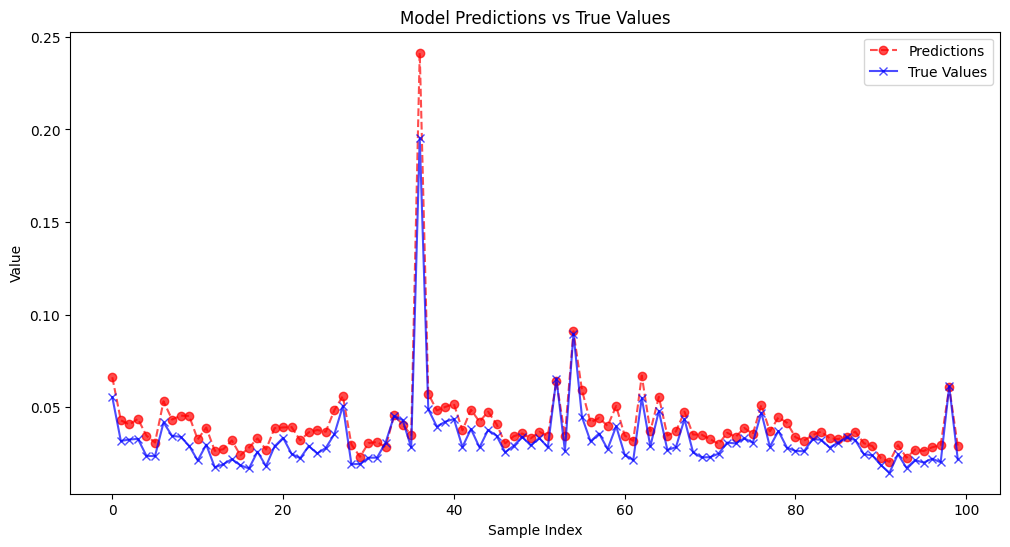

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(np.concatenate(ops[400:500]), label='Predictions', linestyle='--', color='red', alpha=0.7, marker='o')
plt.plot(np.concatenate(tgs[400:500]), label='True Values', linestyle='-', color='blue', alpha=0.7, marker='x')
plt.legend()
plt.title('Model Predictions vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()

In [59]:
lstm_3.eval()

ops = []
tgs = []

with torch.no_grad():
    for inputs, targets in test_loader:
        #inputs = inputs.unsqueeze(2)
        #optimizer.zero_grad()
        outputs = lstm_3(inputs)
        outputs = outputs.squeeze(1)
        ops.append(outputs.flatten().numpy())
        tgs.append(targets.flatten().numpy())
        #loss = criterion(outputs, targets)
        #loss.backward()
        #optimizer.step()
        #train_loss += loss.item()


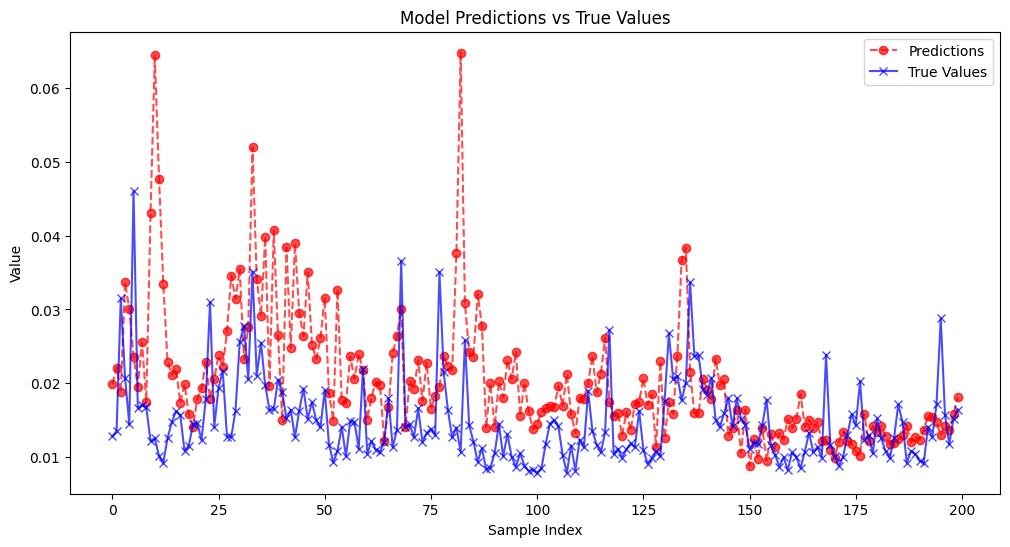

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(np.concatenate(ops[0:200]), label='Predictions', linestyle='--', color='red', alpha=0.7, marker='o')
plt.plot(np.concatenate(tgs[0:200]), label='True Values', linestyle='-', color='blue', alpha=0.7, marker='x')
plt.legend()
plt.title('Model Predictions vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()

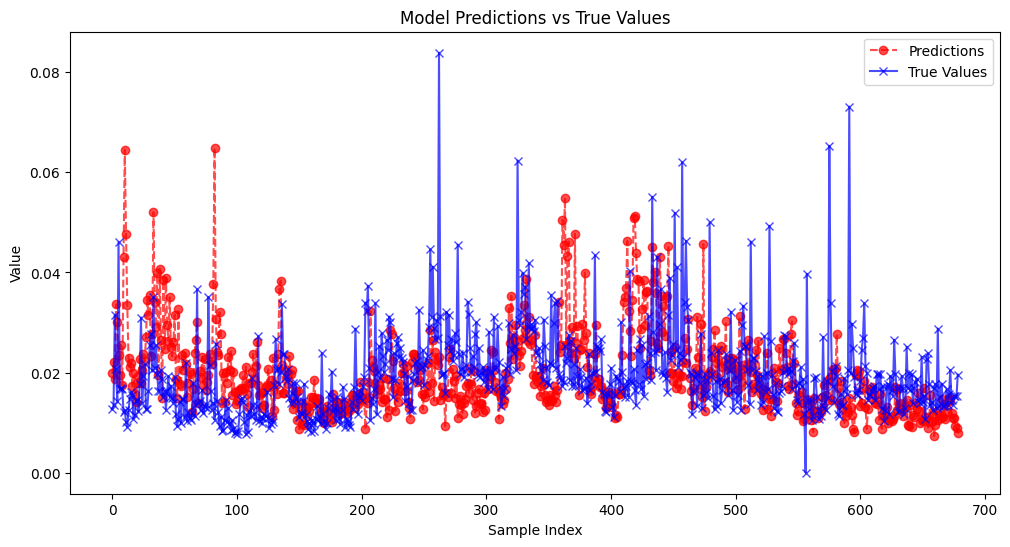

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(np.concatenate(ops), label='Predictions', linestyle='--', color='red', alpha=0.7, marker='o')
plt.plot(np.concatenate(tgs), label='True Values', linestyle='-', color='blue', alpha=0.7, marker='x')
plt.legend()
plt.title('Model Predictions vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()

In [62]:
def calculate_rmspe(y_true, y_pred):
    return torch.sqrt(torch.mean(((y_true - y_pred) / y_true) ** 2))